In [1]:
%load_ext autoreload

In [2]:
import os
import sys
sys.path.append('../src-py/')
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [4]:
%autoreload
import prompted_conclusion_utils as conc_utils
from utils import *
from ca_utils import *

cuda
2022-07-26 11:44:44,524 loading file ../../data-ceph/arguana/arg-generation/claim-target-tagger/model/final-model.pt
2022-07-26 11:45:09,473 SequenceTagger predicts: Dictionary with 4 tags: <unk>, B-CT, I-CT, O


In [5]:
from datasets import load_dataset, load_metric, Dataset

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BartTokenizer, BartForConditionalGeneration

import torch

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
local_home_dir = '../sample-data'

In [8]:
tokenizer = AutoTokenizer.from_pretrained("../sample-data/models/conc-gen-model/")
model = AutoModelForSeq2SeqLM.from_pretrained("../sample-data/models/conc-gen-model/").to(device)

In [9]:
def generate_ds_multi_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, 
                              skip_special_tokens=True, batch_size=16, nb_counters=5):
    multi_attacks = []
    for i in range(nb_counters):
        proc_ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm, conclusion_idx=i), batched=True)
        proc_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        dataloader = torch.utils.data.DataLoader(proc_ds, batch_size=batch_size)
        attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
        
        #get attacked conclusions
        attacked_conclusions = ['' if i > len(x[conclusion_clm])-1 else x[conclusion_clm][i] for x in ds]
        
        multi_attacks.append(zip(attacked_conclusions, attacks))
        
    multi_attacks = list(zip(*multi_attacks)) #convert into a list of tuples, each tuple contains nb_counters
    return multi_attacks

bertscore_metric = load_metric('bertscore')
bleu_score = load_metric('bleu')


def generate_multiple_conclusions(df, post_concepts_clm="post_concepts", output_clm='post_conclusions', num_conclusions=6):
    gen_kwargs = {
        "do_sample": True, 
        "max_length":50,
        "top_p":0.95, 
        "num_beams":1
    }
    
    posts_conclusions = []
    for i in range(num_conclusions):
        control_codes = [x[i] if len(x) > i else '' for x in df[post_concepts_clm].tolist()]
        conclusions   = conc_utils.generate_prompted_conclusions(model, tokenizer, df['post'].tolist(), control_codes, gen_kwargs, batch_size=8)
        posts_conclusions.append(zip(control_codes, conclusions))

    df[output_clm] = list(map(list, zip(*posts_conclusions))) # transpose
    
    return df

def counters_coherence(post_conclusions, post_counters):
    post_counters = [nltk.sent_tokenize(x) for x in post_counters]
    conclusion_counter_sent_pairs = [(x[1], s) for x in zip(post_counters, post_conclusions) for s in x[0]]
    #print(conclusion_counter_sent_pairs)
    conclusions, counter_sents = zip(*conclusion_counter_sent_pairs)
    _, stance_labels, stance_scores = get_stance_scores(conclusions, counter_sents)
    stance_scores = [x[0] * -1 if x[1] == 0 else x[0] for x in zip(stance_scores, stance_labels)]

    #collect counter_scores
    counter_scores = []
    idx = 0
    #print(len(stance_scores))
    for i, post_counter in enumerate(post_counters):
        #print(len(post_counter))
        counter_scores.append(stance_scores[idx: idx + len(post_counter)])
        idx+=len(post_counter)
    
    #print(counter_scores)
    return [np.mean(s) for s in counter_scores]
        
def get_best_counter(post_item):
    if len(post_item) == 0:
        print('found empty')
        return ''
    if len(post_item) == 1:
        print('found one item')
        return post_item[0][2]
    
    _, post_conclusions, post_counters = zip(*post_item)
    counter_scores = counters_coherence(post_conclusions, post_counters)
    #print(sorted(list(zip(counter_scores, post_counters)), key=lambda x: -x[0]))
    #print('===================')
    return post_counters[np.argmax(counter_scores)]

--------

### Generate multiple-counters (pipeline way):

- First: generate multiple conclusions:
    - Mine concepts from the argument
    - Generate conclusions
- Second: Generate a counter for each pair of conclusion-argument

In [10]:
test_df = pd.read_pickle('../sample-data/test_conclusion_all_preprocessed.pkl')

In [11]:
test_df.columns

Index(['post_id', 'split', 'comment_id', 'title', 'post', 'n_sentences',
       'counter', 'bot_comment', 'bart_conclusion', 'conclusion_targets',
       'conclusion_stance'],
      dtype='object')

In [12]:
test_df['post_concepts2'] = conc_utils.get_wiki_concepts(test_df['post'].tolist(), min_len=0, max_concepts=10)

TermWikifierClient: 100%|██████████| 51/51 [00:01<00:00, 44.30it/s]


In [13]:
test_df.to_pickle('../sample-data/test_conclusion_all_preprocessed_multi_conclusions.pkl')

In [ ]:
test_df = generate_multiple_conclusions(test_df, post_concepts_clm="post_concepts2",
                                        output_clm='post_conclusions2', num_conclusions=10)

  0%|          | 0/9 [00:00<?, ?ba/s]

100%|██████████| 1067/1067 [08:24<00:00,  2.12it/s]


  0%|          | 0/9 [00:00<?, ?ba/s]

100%|██████████| 1067/1067 [08:26<00:00,  2.11it/s]


  0%|          | 0/9 [00:00<?, ?ba/s]

100%|██████████| 1067/1067 [08:31<00:00,  2.08it/s]


  0%|          | 0/9 [00:00<?, ?ba/s]

100%|██████████| 1067/1067 [08:26<00:00,  2.11it/s]


  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 1/1067 [00:00<06:59,  2.54it/s]

In [21]:
test_df.to_pickle('../sample-data/test_conclusion_all_preprocessed_multi_conclusions.pkl')

----------

In [22]:
test_df = pd.read_pickle('../sample-data/test_conclusion_all_preprocessed_multi_conclusions.pkl')

In [23]:
test_df['num_concepts'] = test_df.post_concepts2.apply(lambda x: len(x))
test_df['num_conclusions'] = test_df.post_conclusions2.apply(lambda x: len(x))

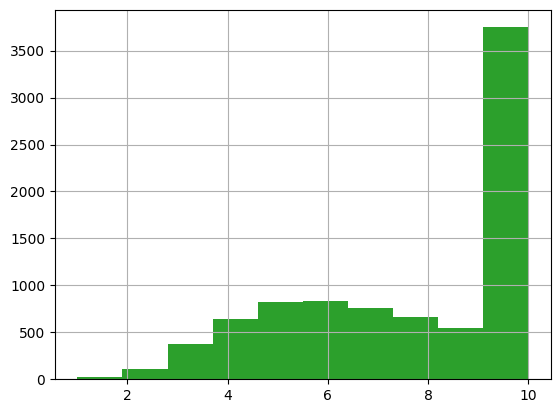

In [26]:
test_df.num_concepts.hist()
plt.show()

#### Now generate multiple counters:

In [27]:
data_unique_path = '../sample-data/test_conclusion_all_preprocessed_multi_conclusions.pkl'
data_path = '../sample-data/test_conclusion_all.pkl'

unique_valid_df = pd.read_pickle(ceph_dir + data_unique_path)
all_valid_df = pd.read_pickle(ceph_dir + data_path)

In [28]:
# Loading Reddit models
known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/models/known-conc-model/checkpoint-9500').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/models/checkpoint-9500')

In [29]:
conclusion_to_concept_dict = {item[1]: item[0] for idx, row in unique_valid_df.iterrows() for item in row['post_conclusions2']}

In [30]:
unique_valid_df['post_conclusions_no_tuples'] = unique_valid_df.post_conclusions2.apply(lambda concept_conclusion_tuples: [x[1] for x in concept_conclusion_tuples])

In [ ]:
gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "min_length":50,
    "no_repeat_ngram_size":3,
    "top_p":0.95, 
    "num_beams":4
}

valid_ds = Dataset.from_pandas(unique_valid_df)
valid_ds = valid_ds.flatten_indices()

multi_conc_attacks = generate_ds_multi_attacks(valid_ds, known_conclusion_model, known_conclusion_tokenizer, 
                                               'post', 'post_conclusions_no_tuples', gen_kwargs, nb_counters=10, batch_size=16)

Flattening the indices:   0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

['Algorithm based dating should be easier', 'Internet trolls are overly upset about "offensive" statements they say out of the habit of doing things you would find abhorrent/disagree with years ago.', "Climate change isn't something that should be addressed on a global level."]
['Discrimination in the media is okay..', 'Society is not ready to accept Asian men that they are not preferred.', 'Pornography and social media are not the problem; Asians are unfairly discriminated against and should be given scientific advancements to improve this.']
["Communism and Nazism are not real and shouldn't be considered rational", 'Top 40 YouTube is overrated.', 'Country of Germany is in such a state that WW2 would be preferable']
['Jews should be shown much more respect and respect in America when it comes to antisemitism (or any form of racism or sexism).', 'Americans should not vote left, but rather focus more on Americans of all races and income (not just Americans)', 'Chief executive officer ar

In [ ]:
multi_conc_attacks = [[(conclusion_to_concept_dict[c[0]], c[0], c[1]) for c in conclusions if c[0] != ''] for conclusions in multi_conc_attacks]

In [ ]:
unique_valid_df['post_counters'] = multi_conc_attacks
unique_valid_df.to_pickle('../sample-data/output/test_all_multi_conclusions_via_pipeline_model_nosample_4beam.pkl')

#### Generate counters with sampling:

In [ ]:
gen_kwargs = {
    "do_sample": True, 
    "max_length":100,
    "min_length":50,
    "top_p":0.95,
    "no_repeat_ngram_size":3,
    "top_k": 50,
    "num_beams":4
}

valid_ds = Dataset.from_pandas(unique_valid_df)
valid_ds = valid_ds.flatten_indices()

multi_conc_attacks = generate_ds_multi_attacks(valid_ds, known_conclusion_model, known_conclusion_tokenizer, 'post', 'post_conclusions_no_tuples', gen_kwargs, nb_counters=10, batch_size=16)

In [ ]:
multi_conc_attacks = [[(conclusion_to_concept_dict[c[0]], c[0], c[1]) for c in conclusions] for conclusions in multi_conc_attacks]

unique_valid_df['post_counters'] = multi_conc_attacks
#unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')
unique_valid_df.to_pickle('../sample-data/output/test_all_multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

In [42]:
print('Done')

Done


#### Choose the best counter:

In [ ]:
#Using our stance classifier
#unique_valid_df = pd.read_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')
unique_valid_df = pd.read_pickle('../sample-data/output/test_all_multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

unique_valid_df['best_counter'] = unique_valid_df.post_counters.apply(lambda post_item: get_best_counter(post_item))
#unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_withsample_4beam.pkl')
unique_valid_df.to_pickle('../sample-data/output/test_all_multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

In [50]:
unique_valid_df = pd.read_pickle('../data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')
#Using our stance classifier
unique_valid_df['best_counter'] = unique_valid_df.post_counters.apply(lambda post_item: get_best_counter(post_item))
#unique_valid_df.to_pickle('../data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')
unique_valid_df.to_pickle('../sample-data/output/multi_conclusions_via_pipeline_model_nosample_4beam.pkl')

/usr/local/lib/python3.6/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one item
found one 

In [55]:
unique_valid_df[['post_counters', 'best_counter']].head()

post_counters  \
500025                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [(Science, Science has proven that the Big Bang is a fact, and that is reason I am not religious.., science has proven that the big bang is a fact, and that is reason you are not religious. science has proved that the universe was created in 6 days, and it's a fact. that's not to say that it's the only fact, but it's certainly the most important.), (Religion, Religion is a stupid way of interpreting science, religion is not a stupid way of interpreting science, it's just one of many ways of interpreting the universe. the big bang is the most obvious example of this. it's a scientific theory that explains how the universe was created.), (Fact, Factually, we know that the Big Bang wasn't the first thing that caused life., the big bang was the first thing that caused life, but it was not the only thing. it was only the first of many, many other things that have caused life. for example, the big bang is the only event that caused the universe to form. it is also the most likely cause of all life.), (Idiot, Idiot, the big bang is a scientific theory. there is no evidence to support it, but it is the only explanation for the universe being the way it is. the universe was created by an unknown 

-------

### Manually evaluate whether prompt-conclusions from both the pipeleined and joint approaches are valid conclusions:

In [18]:
import random

In [19]:
def generate_manual_eval_df(df):
    data = []
    for idx, row in df.iterrows():
        i = 0
        conclusions = [(c, 'pipeline-learning') for c in row['pipelined_conclusions']] + \
                      [(c, 'joint-learning') for c in row['joint_conclusions']] + \
                      [(c, 'joint-learning-two-decoders') for c in row['joint_two_decoders_conclusions']] + \
                      [(row['title'], 'ground-truth')]
        random.shuffle(conclusions)
        for c in conclusions :
            if i == 0:
                data.append([row['post_id'], ' '.join(row['post']), c[0], c[1]])
            else:
                data.append(['', '', c[0], c[1]])
            i+=1
    
    res_df = pd.DataFrame(data, columns=['ID', 'Argument', 'Conclusion', 'Approach name'])
    
    return res_df

In [20]:
stance_based_preds = pd.read_pickle('../sample-data//output/ca-final-models/mt-v4/results/test_preds_df.pkl')
post_to_joint_two_seq_conclusions = pd.Series(stance_based_preds.all_pred_conclusions_no_stance.values, index=stance_based_preds.post_id).to_dict()

In [21]:
pipelined_df = pd.read_pickle('../sample-data/sample_test_conclusion_all_preprocessed_multi_conclusions.pkl')
pipelined_df['pipelined_conclusions'] = pipelined_df.post_conclusions.apply(lambda concs: [x[1] for x in concs if x[0] != ''])

joint_df = pd.read_pickle('../sample-data/output/multi_conclusions_via_joint_model_withsampling_4beams.pkl')
joint_df['joint_conclusions'] = joint_df['post_counters'].apply(lambda c: [x[1] for x in c if c[0] != ''])
post_to_joint_conclusions = pd.Series(joint_df.joint_conclusions.values, index=joint_df.post_id).to_dict()

In [24]:
sample_test[sample_test.post_id == "t3_amjwmo"][['title', 'bart_conclusion', 'joint_conclusions', 'joint_two_decoders_conclusions']].head()

,title,bart_conclusion,joint_conclusions,joint_two_decoders_conclusions
438892,Artificial General Intelligence does not need to be conscious to be more intelligent or effective than humans,i needs to be more intelligent in order to be an agi,"[Scientific law is the only thing that can make AGI generally intelligent., Argument that AGI needs to have a subjective experience in order to be generally intelligent is flawed.]","[ AI needs the algorithms that make us intelligent and by having these missing pieces they will be, AI needs the algorithms that make us intelligent and by having these missing pieces they will]"


In [16]:
#Test only posts where we found at least 3 concepts
pipelined_df = pipelined_df[pipelined_df.post_concepts.str.len() > 2]
sample_test = pipelined_df.sample(50)
sample_test['joint_conclusions'] = sample_test.post_id.apply(lambda x: post_to_joint_conclusions[x])
sample_test['joint_two_decoders_conclusions'] = sample_test.post_id.apply(lambda x: post_to_joint_two_seq_conclusions[x])
sample_test['joint_conclusions']     = sample_test.joint_conclusions.apply(lambda x: x[:2])
sample_test['joint_two_decoders_conclusions']     = sample_test.joint_two_decoders_conclusions.apply(lambda x: x[:2])
sample_test['pipelined_conclusions'] = sample_test.pipelined_conclusions.apply(lambda x: x[:2])

In [56]:
eval_df = generate_manual_eval_df(sample_test)

In [57]:
eval_df[['ID', 'Argument', 'Conclusion', 'Approach name']].head(n=10)

,ID,Argument,Conclusion,Approach name
0,t3_aiwppt,"models of climate change predict, in the very near future, existential threats to humanity. in particular are weather effects that will drastically reduce food supplies and access to potable water. in the western hemisphere, it is obvious that this will be far more disastrous to those south of the us border where, even right now, access to food and water is a real issue for millions of people. while the proposed border wall may not be entirely justifiable in its ability to stop current illegal immigration and illicit transport of contraband, in the event of a massive migration, greater in scale by magnitudes than that seen in europe, a border wall will be absolutely necessary to stop the influx. now, one might argue that it is morally unjustifiable to turn away the starving masses, which is a nice sentiment. however, this sentiment fails at practicality: this country s own food supply will also be taxed and to let in millions will only ensure that even more people will starve together as opposed to some living and some dying. if one were to argue that we caused more pollution than they did, and so should not live whilst they die, then the rational answer is to go ahead and commit suicide now so that you will not contribute more pollution or reduce any more resources that you feel others have more right to possess. doing otherwise is only to make the moral judgement for others by removing their agency. would a person who claims that we don t deserve to live instead of these potential refugees feel justified to murder infants now? if not, then how could they argue that an arbitrary amount of time will serve to justify that same death for wrongs committed at the same time that the same person was an infant? or before they were even born since the worst of the pollution caused by the us was done between 40 to 70 years ago ? it is not justifiable because neither the infant nor the potential refugee had a part in the damage done. so, what is left to argue? in the event of a refugee crisis, will a wall stop more refugees than no wall? obviously it will. is the cost of constructing one now less than it will be in the future? yes, it is, and it would have been cheaper still had it been built 5, 10, or 20 years ago. the worst case scenario of building the wall now is that it would be totally ineffective at the stated purpose and it would cost the government money that would otherwise be earmarked off to some other pork barrel project. that is very little risk when considered against the future benefit that can be provided.",Pollution is not morally justified and building a border wall is the best way to stop the immigration crisis.,joint-learning
1,,,To believe Climate Change models are correct but to oppose a border wall is an irrational position regardless of politics.,ground-truth
2,,,Drinking water and committing suicide at an infant's birth is morally unjustifiable.,pipeline-learning
3,,,"Climate change is a real issue, and building a border wall is necessary to stop the influx of refugees.",joint-learning
4,,,"Climate change is far more of an issue than the proposed border wall, it has a much greater risk of increasing the risk of global extinction than a wall.",pipeline-learning
5,,,The proposed border wall between the US and Mexico will not be necessary in the near future,joint-learning-two-decoders
6,,,The United States should not have a wall along the US-Mexico border.,joint-learning-two-decoders
7,t3_a4pqnh,"i've spent a lot of my life being told to be polite when in the presence of those who disagree with me. this is to be expected, and welcomed even; no one wants to talk about hot button issues with an asshole. however, i see many people take it a step too far. one person, who i am very close to, once went so far as to say this: 'sometimes you just have to shut up, nod, and smile your way out of the conversation. ' except doing so would be tantamount to deception, as you ar

In [58]:
eval_df.to_csv('../data/manual_evaluation/eval_conclusion_sample.csv')

In [47]:
eval_df['arg_len'] = eval_df.Argument.apply(lambda x: len(x.split()))

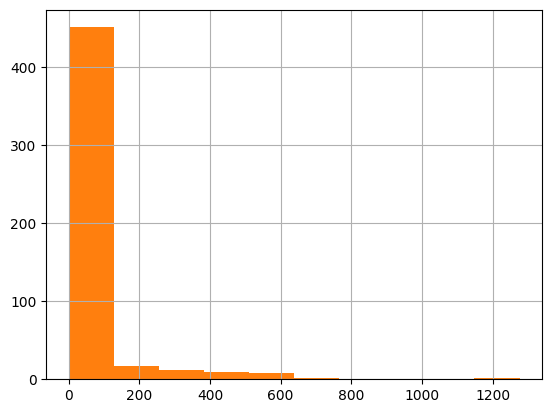

In [49]:
eval_df.arg_len.hist()
plt.show()

In [50]:
eval_df.arg_len.mean()

36.752